### For training ViT-RoBERTa model

In [1]:
import transformers
import datasets
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path
import json
import os
import random
from torch.utils.data import Dataset
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM
from transformers import RobertaTokenizerFast
from transformers import ViTFeatureExtractor, ViTModel
from transformers import VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments
from transformers import default_data_collator
from transformers import EarlyStoppingCallback
from utils import *
from dataset import *

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4
PATIENCE = 10
SEED = 42
MAX_LEN = 50
MAX_NEW_TOkENS = 50
TRAIN_EPOCHS = 20
WEIGHT_DECAY = 0.1

In [3]:
df=create_input_df(karpathy_json_path='/home/prabhu.v/nlp_proj/data/dataset_flickr8k.json', 
                   image_folder='/home/prabhu.v/nlp_proj/data/flickr8k/Images/')

In [4]:
grouped = df.groupby(['split'])
df_train = grouped.get_group("train")
df_val = grouped.get_group("val")
df_test = grouped.get_group("test")
df_train = df_train.drop('split', axis=1).reset_index(drop=True)
df_val = df_val.drop('split', axis=1).reset_index(drop=True)
df_test = df_test.drop('split', axis=1).reset_index(drop=True)

In [3]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_len=MAX_LEN)

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [7]:
train_dataset = F8kDataset(df=df_train,tokenizer=tokenizer,feature_extractor= feature_extractor,decoder_max_length=MAX_LEN)
eval_dataset = F8kDataset(df=df_val,tokenizer=tokenizer,feature_extractor= feature_extractor,decoder_max_length=MAX_LEN)
test_dataset = F8kDataset(df=df_test,tokenizer=tokenizer,feature_extractor= feature_extractor,decoder_max_length=MAX_LEN)

In [ ]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "roberta-base", tie_encoder_decoder=True)

In [9]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = MAX_LEN
model.config.max_new_tokens = MAX_NEW_TOkENS
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 3

In [ ]:
rouge = datasets.load_metric("rouge")

def compute_rouge(pred):
    """
    Calculates rouge score from predictions and targets from VIT Roberta

    Parameters:-
    pred: Predection from model trainer

    Returns:- Rouge precision, accuracy and recall
    """
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [ ]:
captioning_model = 'vit_roberta_model_checkpoint'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    overwrite_output_dir=True,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model = 'rouge2_fmeasure',
    dataloader_num_workers=4,
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_rouge,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

In [12]:
# Fine-tune the model, training and evaluating on the train dataset
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.600664,0.107200,0.104800,0.101000
2,4.002900,2.299404,0.121100,0.132300,0.121200
3,2.202500,2.255892,0.121500,0.130000,0.120300
4,1.816400,2.277328,0.121600,0.133000,0.121900
5,1.551800,2.320606,0.129500,0.132000,0.125900
6,1.340300,2.397891,0.128400,0.134500,0.126200
7,1.151000,2.455520,0.124400,0.130100,0.122200
8,0.982100,2.540054,0.118500,0.127300,0.117800
9,0.831700,2.637353,0.118000,0.131000,0.118800
10,0.705600,2.717000,0.115400,0.123400,0.114400


/home/prabhu.v/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Removed shared tensor {'decoder.lm_head.decoder.bias', 'decoder.lm_head.decoder.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
There were missing keys in the checkpoint model loaded: ['decoder.lm_head.decoder.weight', 'decoder.lm_head.decoder.bias'].


TrainOutput(global_step=15008, training_loss=1.16294549726474, metrics={'train_runtime': 10800.0495, 'train_samples_per_second': 55.555, 'train_steps_per_second': 1.737, 'total_flos': 8.690115836215296e+19, 'train_loss': 1.16294549726474, 'epoch': 16.0})

In [14]:
trainer.save_model('vit_roberta_model')

In [ ]:
t = VisionEncoderDecoderModel.from_pretrained('vit_roberta_model')

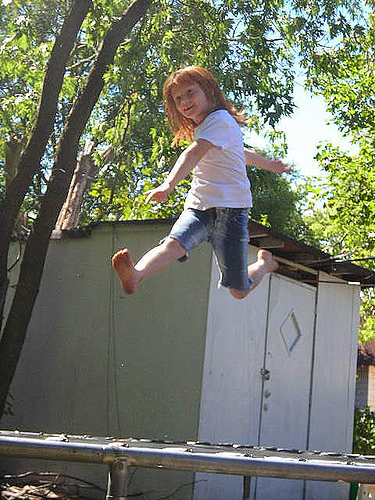

In [23]:
temp = df_test.sample(1).images.iloc[0]
Image.open(temp).convert("RGB")

In [24]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'A little girl is jumping in the air.'

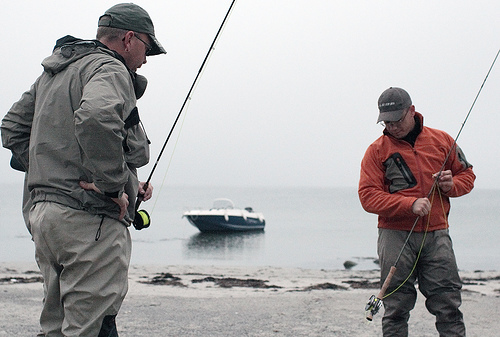

In [19]:
temp = df_test.sample(1).images.iloc[0]
Image.open(temp).convert("RGB")

In [20]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'Two men are standing on the shore holding a pole.'

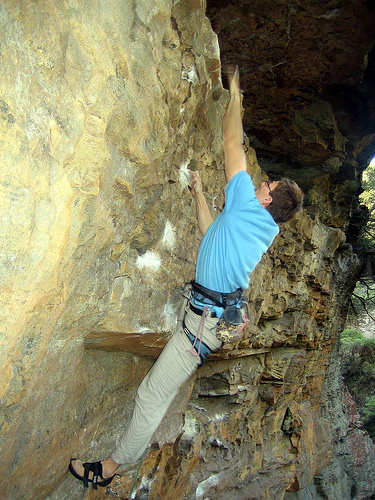

In [6]:
temp = '../data/flickr8k/Images/415793623_6c1225ae27.jpg'
Image.open(temp).convert("RGB")

In [7]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'A man in a red shirt is climbing a rock face.'

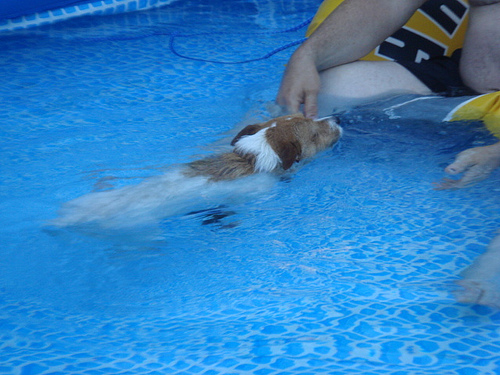

In [8]:
temp = '../data/flickr8k/Images/2677656448_6b7e7702af.jpg'
Image.open(temp).convert("RGB")

In [9]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'A brown and white dog jumps into a pool of water.'

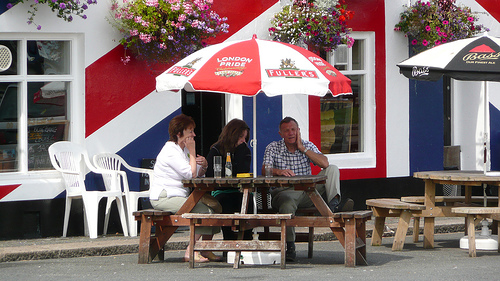

In [10]:
temp = '../data/flickr8k/Images/1258913059_07c613f7ff.jpg'
Image.open(temp).convert("RGB")

In [11]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'Two people are sitting on a bench in front of a restaurant.'

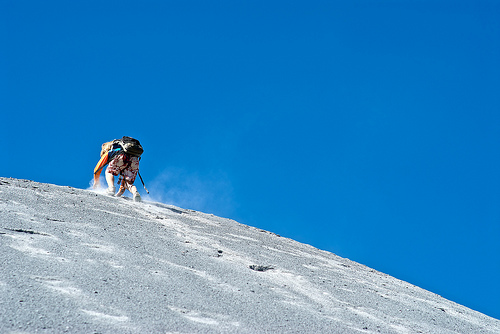

In [24]:
temp = '../data/flickr8k/Images/3745451546_fc8ec70cbd.jpg'
Image.open(temp).convert("RGB")

In [25]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'A person is on a snow covered mountain.'

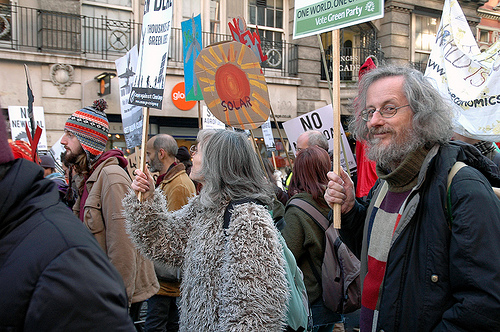

In [26]:
temp = '../data/flickr8k/Images/3100251515_c68027cc22.jpg'
Image.open(temp).convert("RGB")

In [27]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values,max_new_tokens=100,num_beams=3)[0],skip_special_tokens=True)

'A crowd of people are standing in the streets.'